In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [2]:
#设置种子和设备
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [3]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([-5,5], [0,np.pi/2], 101, 101) #获取训练数据，第一个参数是x的取值范围，第二个参数是t的取值范围，第三个和第四个参数分别是x和t的采样点数
#这样，res是一个形状为(51*51,2)的数组，其中每一行代表一个(x,t)点的坐标，代表配位点/训练数据。b_left、b_right、b_upper和b_lower分别是边界条件的训练点，这些点用于训练PINNsformer模型。
res_test, _, _, _, _ = get_data([-5,5], [0,np.pi/2], 512, 201) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

#将数据转换为时间序列，输入的数据形状为(N, 2)，第一列x第二列t。最后返回的是一个伪时间序列数据，形状为(N, num_step, 2)，step则代表Δt，是伪时间序列的递增量。相当于把N个[x,t]转换为{[x,t],[x,t+Δt],[x,t+2Δt],...,[x,t+(num_step-1)Δt]}，即每个空间位置都有一个时间序列。
res = make_time_sequence(res, num_step=5, step=1e-4) #配位点的时间序列数据，res形状变为(51*51, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #左边界条件的时间序列数据，b_left形状变为(51, 5, 2)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #右边界条件的时间序列数据，b_right形状变为(51, 5, 2)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #上边界条件的时间序列数据，b_upper形状变为(51, 5, 2)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #下边界条件的时间序列数据，b_lower形状变为(51, 5, 2)

#将数据转移到显卡上
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

#将数据分离为x和t的部分
x_res, t_res = res[:,:,0:1], res[:,:,1:2] #将res的第一列作为x，第二列作为t,这样x_res和t_res的形状都是(51*51, 5, 1)，即51*51个时间序列，每个(x,t)点都有5个时间步的序列数据
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2] #将b_left的第一列作为x，第二列作为t,这样x_left和t_left的形状都是(51, 5, 1)，即每个左边界点都有5个时间步的序列数据
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2] #将b_right的第一列作为x，第二列作为t,这样x_right和t_right的形状都是(51, 5, 1)，即每个右边界点都有5个时间步的序列数据
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2] #将b_upper的第一列作为x，第二列作为t,这样x_upper和t_upper的形状都是(51, 5, 1)，即每个上边界点都有5个时间步的序列数据
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2] #将b_lower的第一列作为x，第二列作为t,这样x_lower和t_lower的形状都是(51, 5, 1)，即每个下边界点都有5个时间步的序列数据

#初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
def init_weights(m):
    if isinstance(m, nn.Linear): #判断是否是线性层
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=2, heads=4).to(device) #创建PINNsformer模型，模型输出维度为1，outputlayer模块的隐藏层维度为512，数据的特征嵌入维度为32，编码器和解码器的层数为1，注意力机制的头数为2

model.apply(init_weights) #初始化模型中线性层的权重和偏置
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

print(model) #打印模型结构
print(get_n_params(model)) #打印模型参数数量

/tmp/ipykernel_1342561/2878451743.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (lin

In [5]:
loss_track = [] #记录loss

for i in tqdm(range(500)): #训练500次
    def closure():
        pred_res = model(x_res, t_res) #得到配位点的预测结果
        pred_left = model(x_left, t_left) #得到左边界点的预测结果
        pred_right = model(x_right, t_right) #得到右边界点的预测结果
        pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
        pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

        #计算配位点的时间导数u_t和空间导数u_x
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        pred_x_upper = torch.autograd.grad(pred_upper, x_upper, grad_outputs=torch.ones_like(pred_upper), retain_graph=True, create_graph=True)[0]
        pred_x_lower = torch.autograd.grad(pred_lower, x_lower, grad_outputs=torch.ones_like(pred_lower), retain_graph=True, create_graph=True)[0]

        #计算损失，共三项损失
        loss_res = torch.mean((u_t - 0.0001 * u_xx + 5 * pred_res ** 3- 5 * pred_res) ** 2)
        # loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        # loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower)**2)+torch.mean((pred_x_upper - pred_x_lower)**2)
        # loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - x_left[:,0]**2*torch.cos(torch.pi*x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:08<1:10:26,  8.47s/it]

  0%|          | 2/500 [00:16<1:08:07,  8.21s/it]

  1%|          | 3/500 [00:25<1:10:13,  8.48s/it]

  1%|          | 4/500 [00:33<1:08:47,  8.32s/it]

  1%|          | 5/500 [00:41<1:07:56,  8.24s/it]

  1%|          | 6/500 [00:49<1:07:25,  8.19s/it]

  1%|▏         | 7/500 [00:57<1:07:03,  8.16s/it]

  2%|▏         | 8/500 [01:05<1:06:45,  8.14s/it]

  2%|▏         | 9/500 [01:13<1:06:29,  8.13s/it]

  2%|▏         | 10/500 [01:21<1:06:18,  8.12s/it]

  2%|▏         | 11/500 [01:31<1:09:57,  8.58s/it]

  2%|▏         | 12/500 [01:39<1:08:37,  8.44s/it]

  3%|▎         | 13/500 [01:47<1:07:42,  8.34s/it]

  3%|▎         | 14/500 [01:55<1:06:57,  8.27s/it]

  3%|▎         | 15/500 [02:04<1:06:28,  8.22s/it]

  3%|▎         | 16/500 [02:12<1:06:01,  8.19s/it]

  3%|▎         | 17/500 [02:20<1:05:44,  8.17s/it]

  4%|▎         | 18/500 [02:28<1:05:30,  8.15s/it]

  4%|▍         | 19/500 [02:36<1:06:10,  8.25s/it]

  4%|▍         | 20/500 [02:45<1:06:38,  8.33s/it]

  4%|▍         | 21/500 [02:54<1:07:47,  8.49s/it]

  4%|▍         | 22/500 [03:03<1:08:33,  8.61s/it]

  5%|▍         | 23/500 [03:11<1:08:07,  8.57s/it]

  5%|▍         | 24/500 [03:20<1:09:37,  8.78s/it]

  5%|▌         | 25/500 [03:30<1:11:33,  9.04s/it]

  5%|▌         | 26/500 [03:40<1:13:45,  9.34s/it]

  5%|▌         | 27/500 [03:50<1:14:17,  9.42s/it]

  6%|▌         | 28/500 [03:59<1:14:40,  9.49s/it]

  6%|▌         | 29/500 [04:08<1:13:05,  9.31s/it]

  6%|▌         | 30/500 [04:18<1:13:41,  9.41s/it]

  6%|▌         | 31/500 [04:28<1:14:58,  9.59s/it]

  6%|▋         | 32/500 [04:37<1:14:04,  9.50s/it]

  7%|▋         | 33/500 [04:46<1:13:22,  9.43s/it]

  7%|▋         | 34/500 [04:56<1:13:42,  9.49s/it]

  7%|▋         | 35/500 [05:05<1:12:05,  9.30s/it]

  7%|▋         | 36/500 [05:15<1:13:34,  9.51s/it]

  7%|▋         | 37/500 [05:23<1:11:06,  9.21s/it]

  8%|▊         | 38/500 [05:32<1:10:12,  9.12s/it]

  8%|▊         | 39/500 [05:42<1:10:21,  9.16s/it]

  8%|▊         | 40/500 [05:50<1:09:32,  9.07s/it]

  8%|▊         | 41/500 [05:59<1:08:06,  8.90s/it]

  8%|▊         | 42/500 [06:09<1:09:39,  9.12s/it]

  9%|▊         | 43/500 [06:18<1:10:41,  9.28s/it]

  9%|▉         | 44/500 [06:28<1:11:16,  9.38s/it]

  9%|▉         | 45/500 [06:37<1:11:41,  9.45s/it]

  9%|▉         | 46/500 [06:49<1:16:12, 10.07s/it]

  9%|▉         | 47/500 [06:52<59:17,  7.85s/it]  

 10%|▉         | 48/500 [06:54<47:26,  6.30s/it]

 10%|▉         | 49/500 [06:57<39:10,  5.21s/it]

 10%|█         | 50/500 [07:00<33:22,  4.45s/it]

 10%|█         | 51/500 [07:02<29:18,  3.92s/it]

 10%|█         | 52/500 [07:05<26:27,  3.54s/it]

 11%|█         | 53/500 [07:08<24:27,  3.28s/it]

 11%|█         | 54/500 [07:10<23:02,  3.10s/it]

 11%|█         | 55/500 [07:13<22:01,  2.97s/it]

 11%|█         | 56/500 [07:16<21:19,  2.88s/it]

 11%|█▏        | 57/500 [07:18<20:48,  2.82s/it]

 12%|█▏        | 58/500 [07:21<20:26,  2.77s/it]

 12%|█▏        | 59/500 [07:24<20:09,  2.74s/it]

 12%|█▏        | 60/500 [07:26<19:57,  2.72s/it]

 12%|█▏        | 61/500 [07:29<19:48,  2.71s/it]

 12%|█▏        | 62/500 [07:32<19:41,  2.70s/it]

 13%|█▎        | 63/500 [07:34<19:36,  2.69s/it]

 13%|█▎        | 64/500 [07:37<19:31,  2.69s/it]

 13%|█▎        | 65/500 [07:40<19:26,  2.68s/it]

 13%|█▎        | 66/500 [07:42<19:24,  2.68s/it]

 13%|█▎        | 67/500 [07:45<19:21,  2.68s/it]

 14%|█▎        | 68/500 [07:48<19:17,  2.68s/it]

 14%|█▍        | 69/500 [07:50<19:14,  2.68s/it]

 14%|█▍        | 70/500 [07:53<19:10,  2.68s/it]

 14%|█▍        | 71/500 [07:56<19:07,  2.68s/it]

 14%|█▍        | 72/500 [07:59<19:04,  2.67s/it]

 15%|█▍        | 73/500 [08:01<19:02,  2.67s/it]

 15%|█▍        | 74/500 [08:04<18:59,  2.67s/it]

 15%|█▌        | 75/500 [08:07<18:57,  2.68s/it]

 15%|█▌        | 76/500 [08:09<18:54,  2.68s/it]

 15%|█▌        | 77/500 [08:12<18:51,  2.68s/it]

 16%|█▌        | 78/500 [08:15<18:50,  2.68s/it]

 16%|█▌        | 79/500 [08:17<18:46,  2.68s/it]

 16%|█▌        | 80/500 [08:20<18:44,  2.68s/it]

 16%|█▌        | 81/500 [08:23<18:43,  2.68s/it]

 16%|█▋        | 82/500 [08:25<18:39,  2.68s/it]

 17%|█▋        | 83/500 [08:28<18:36,  2.68s/it]

 17%|█▋        | 84/500 [08:31<18:33,  2.68s/it]

 17%|█▋        | 85/500 [08:33<18:30,  2.68s/it]

 17%|█▋        | 86/500 [08:36<18:28,  2.68s/it]

 17%|█▋        | 87/500 [08:39<18:25,  2.68s/it]

 18%|█▊        | 88/500 [08:41<18:23,  2.68s/it]

 18%|█▊        | 89/500 [08:44<18:20,  2.68s/it]

 18%|█▊        | 90/500 [08:47<18:17,  2.68s/it]

 18%|█▊        | 91/500 [08:49<18:14,  2.68s/it]

 18%|█▊        | 92/500 [08:52<18:11,  2.68s/it]

 19%|█▊        | 93/500 [08:55<18:08,  2.67s/it]

 19%|█▉        | 94/500 [08:57<18:06,  2.68s/it]

 19%|█▉        | 95/500 [09:00<18:03,  2.67s/it]

 19%|█▉        | 96/500 [09:03<18:01,  2.68s/it]

 19%|█▉        | 97/500 [09:05<17:58,  2.68s/it]

 20%|█▉        | 98/500 [09:08<17:55,  2.68s/it]

 20%|█▉        | 99/500 [09:11<17:52,  2.68s/it]

 20%|██        | 100/500 [09:13<17:49,  2.67s/it]

 20%|██        | 101/500 [09:16<17:47,  2.67s/it]

 20%|██        | 102/500 [09:19<17:44,  2.67s/it]

 21%|██        | 103/500 [09:21<17:41,  2.67s/it]

 21%|██        | 104/500 [09:24<17:39,  2.67s/it]

 21%|██        | 105/500 [09:27<17:36,  2.67s/it]

 21%|██        | 106/500 [09:29<17:33,  2.67s/it]

 21%|██▏       | 107/500 [09:32<17:30,  2.67s/it]

 22%|██▏       | 108/500 [09:35<17:28,  2.67s/it]

 22%|██▏       | 109/500 [09:38<17:25,  2.67s/it]

 22%|██▏       | 110/500 [09:40<17:22,  2.67s/it]

 22%|██▏       | 111/500 [09:43<17:19,  2.67s/it]

 22%|██▏       | 112/500 [09:46<17:17,  2.67s/it]

 23%|██▎       | 113/500 [09:48<17:14,  2.67s/it]

 23%|██▎       | 114/500 [09:51<17:12,  2.67s/it]

 23%|██▎       | 115/500 [09:54<17:09,  2.67s/it]

 23%|██▎       | 116/500 [09:56<17:06,  2.67s/it]

 23%|██▎       | 117/500 [09:59<17:04,  2.67s/it]

 24%|██▎       | 118/500 [10:02<17:01,  2.67s/it]

 24%|██▍       | 119/500 [10:04<16:59,  2.67s/it]

 24%|██▍       | 120/500 [10:07<16:56,  2.67s/it]

 24%|██▍       | 121/500 [10:10<16:53,  2.67s/it]

 24%|██▍       | 122/500 [10:12<16:50,  2.67s/it]

 25%|██▍       | 123/500 [10:15<16:48,  2.68s/it]

 25%|██▍       | 124/500 [10:18<16:46,  2.68s/it]

 25%|██▌       | 125/500 [10:20<16:44,  2.68s/it]

 25%|██▌       | 126/500 [10:23<16:41,  2.68s/it]

 25%|██▌       | 127/500 [10:26<16:38,  2.68s/it]

 26%|██▌       | 128/500 [10:28<16:38,  2.68s/it]

 26%|██▌       | 129/500 [10:31<16:35,  2.68s/it]

 26%|██▌       | 130/500 [10:34<16:31,  2.68s/it]

 26%|██▌       | 131/500 [10:36<16:30,  2.68s/it]

 26%|██▋       | 132/500 [10:39<16:26,  2.68s/it]

 27%|██▋       | 133/500 [10:42<16:22,  2.68s/it]

 27%|██▋       | 134/500 [10:44<16:19,  2.68s/it]

 27%|██▋       | 135/500 [10:47<16:16,  2.68s/it]

 27%|██▋       | 136/500 [10:50<16:13,  2.68s/it]

 27%|██▋       | 137/500 [10:52<16:10,  2.67s/it]

 28%|██▊       | 138/500 [10:55<16:08,  2.68s/it]

 28%|██▊       | 139/500 [10:58<16:05,  2.68s/it]

 28%|██▊       | 140/500 [11:00<16:03,  2.68s/it]

 28%|██▊       | 141/500 [11:03<16:00,  2.68s/it]

 28%|██▊       | 142/500 [11:06<15:58,  2.68s/it]

 29%|██▊       | 143/500 [11:09<15:55,  2.68s/it]

 29%|██▉       | 144/500 [11:11<15:52,  2.68s/it]

 29%|██▉       | 145/500 [11:14<15:50,  2.68s/it]

 29%|██▉       | 146/500 [11:17<15:47,  2.68s/it]

 29%|██▉       | 147/500 [11:19<15:44,  2.67s/it]

 30%|██▉       | 148/500 [11:22<15:41,  2.67s/it]

 30%|██▉       | 149/500 [11:25<15:38,  2.67s/it]

 30%|███       | 150/500 [11:27<15:36,  2.67s/it]

 30%|███       | 151/500 [11:30<15:33,  2.68s/it]

 30%|███       | 152/500 [11:33<15:30,  2.67s/it]

 31%|███       | 153/500 [11:35<15:27,  2.67s/it]

 31%|███       | 154/500 [11:38<15:25,  2.67s/it]

 31%|███       | 155/500 [11:41<15:22,  2.67s/it]

 31%|███       | 156/500 [11:43<15:19,  2.67s/it]

 31%|███▏      | 157/500 [11:46<15:16,  2.67s/it]

 32%|███▏      | 158/500 [11:49<15:14,  2.67s/it]

 32%|███▏      | 159/500 [11:51<15:11,  2.67s/it]

 32%|███▏      | 160/500 [11:54<15:09,  2.67s/it]

 32%|███▏      | 161/500 [11:57<15:06,  2.67s/it]

 32%|███▏      | 162/500 [11:59<15:03,  2.67s/it]

 33%|███▎      | 163/500 [12:02<15:01,  2.67s/it]

 33%|███▎      | 164/500 [12:05<14:58,  2.67s/it]

 33%|███▎      | 165/500 [12:07<14:55,  2.67s/it]

 33%|███▎      | 166/500 [12:10<14:52,  2.67s/it]

 33%|███▎      | 167/500 [12:13<14:50,  2.67s/it]

 34%|███▎      | 168/500 [12:15<14:47,  2.67s/it]

 34%|███▍      | 169/500 [12:18<14:45,  2.67s/it]

 34%|███▍      | 170/500 [12:21<14:42,  2.67s/it]

 34%|███▍      | 171/500 [12:23<14:39,  2.67s/it]

 34%|███▍      | 172/500 [12:26<14:36,  2.67s/it]

 35%|███▍      | 173/500 [12:29<14:34,  2.67s/it]

 35%|███▍      | 174/500 [12:31<14:31,  2.67s/it]

 35%|███▌      | 175/500 [12:34<14:29,  2.67s/it]

 35%|███▌      | 176/500 [12:37<14:26,  2.67s/it]

 35%|███▌      | 177/500 [12:39<14:23,  2.67s/it]

 36%|███▌      | 178/500 [12:42<14:20,  2.67s/it]

 36%|███▌      | 179/500 [12:45<14:18,  2.68s/it]

 36%|███▌      | 180/500 [12:47<14:15,  2.67s/it]

 36%|███▌      | 181/500 [12:50<14:13,  2.68s/it]

 36%|███▋      | 182/500 [12:53<14:10,  2.67s/it]

 37%|███▋      | 183/500 [12:55<14:07,  2.67s/it]

 37%|███▋      | 184/500 [12:58<14:05,  2.67s/it]

 37%|███▋      | 185/500 [13:01<14:03,  2.68s/it]

 37%|███▋      | 186/500 [13:04<14:00,  2.68s/it]

 37%|███▋      | 187/500 [13:06<13:57,  2.68s/it]

 38%|███▊      | 188/500 [13:09<13:54,  2.68s/it]

 38%|███▊      | 189/500 [13:12<13:52,  2.68s/it]

 38%|███▊      | 190/500 [13:14<13:49,  2.67s/it]

 38%|███▊      | 191/500 [13:17<13:46,  2.67s/it]

 38%|███▊      | 192/500 [13:20<13:44,  2.68s/it]

 39%|███▊      | 193/500 [13:22<13:41,  2.68s/it]

 39%|███▉      | 194/500 [13:25<13:38,  2.67s/it]

 39%|███▉      | 195/500 [13:28<13:35,  2.68s/it]

 39%|███▉      | 196/500 [13:30<13:33,  2.67s/it]

 39%|███▉      | 197/500 [13:33<13:30,  2.67s/it]

 40%|███▉      | 198/500 [13:36<13:28,  2.68s/it]

 40%|███▉      | 199/500 [13:38<13:25,  2.68s/it]

 40%|████      | 200/500 [13:41<13:22,  2.68s/it]

 40%|████      | 201/500 [13:44<13:20,  2.68s/it]

 40%|████      | 202/500 [13:46<13:17,  2.67s/it]

 41%|████      | 203/500 [13:49<13:15,  2.68s/it]

 41%|████      | 204/500 [13:52<13:12,  2.68s/it]

 41%|████      | 205/500 [13:54<13:09,  2.68s/it]

 41%|████      | 206/500 [13:57<13:07,  2.68s/it]

 41%|████▏     | 207/500 [14:00<13:04,  2.68s/it]

 42%|████▏     | 208/500 [14:02<13:02,  2.68s/it]

 42%|████▏     | 209/500 [14:05<12:59,  2.68s/it]

 42%|████▏     | 210/500 [14:08<12:56,  2.68s/it]

 42%|████▏     | 211/500 [14:10<12:53,  2.68s/it]

 42%|████▏     | 212/500 [14:13<12:50,  2.68s/it]

 43%|████▎     | 213/500 [14:16<12:48,  2.68s/it]

 43%|████▎     | 214/500 [14:18<12:45,  2.68s/it]

 43%|████▎     | 215/500 [14:21<12:43,  2.68s/it]

 43%|████▎     | 216/500 [14:24<12:40,  2.68s/it]

 43%|████▎     | 217/500 [14:26<12:37,  2.68s/it]

 44%|████▎     | 218/500 [14:29<12:35,  2.68s/it]

 44%|████▍     | 219/500 [14:32<12:32,  2.68s/it]

 44%|████▍     | 220/500 [14:35<12:29,  2.68s/it]

 44%|████▍     | 221/500 [14:37<12:26,  2.67s/it]

 44%|████▍     | 222/500 [14:40<12:23,  2.67s/it]

 45%|████▍     | 223/500 [14:43<12:21,  2.68s/it]

 45%|████▍     | 224/500 [14:45<12:18,  2.68s/it]

 45%|████▌     | 225/500 [14:48<12:15,  2.67s/it]

 45%|████▌     | 226/500 [14:51<12:12,  2.67s/it]

 45%|████▌     | 227/500 [14:53<12:09,  2.67s/it]

 46%|████▌     | 228/500 [14:56<12:07,  2.67s/it]

 46%|████▌     | 229/500 [14:59<12:04,  2.67s/it]

 46%|████▌     | 230/500 [15:01<12:02,  2.67s/it]

 46%|████▌     | 231/500 [15:04<11:59,  2.67s/it]

 46%|████▋     | 232/500 [15:07<11:56,  2.67s/it]

 47%|████▋     | 233/500 [15:09<11:53,  2.67s/it]

 47%|████▋     | 234/500 [15:12<11:51,  2.67s/it]

 47%|████▋     | 235/500 [15:15<11:48,  2.67s/it]

 47%|████▋     | 236/500 [15:17<11:45,  2.67s/it]

 47%|████▋     | 237/500 [15:20<11:42,  2.67s/it]

 48%|████▊     | 238/500 [15:23<11:40,  2.67s/it]

 48%|████▊     | 239/500 [15:25<11:38,  2.67s/it]

 48%|████▊     | 240/500 [15:28<11:35,  2.67s/it]

 48%|████▊     | 241/500 [15:31<11:32,  2.67s/it]

 48%|████▊     | 242/500 [15:33<11:29,  2.67s/it]

 49%|████▊     | 243/500 [15:36<11:27,  2.67s/it]

 49%|████▉     | 244/500 [15:39<11:24,  2.67s/it]

 49%|████▉     | 245/500 [15:41<11:21,  2.67s/it]

 49%|████▉     | 246/500 [15:44<11:19,  2.67s/it]

 49%|████▉     | 247/500 [15:47<11:17,  2.68s/it]

 50%|████▉     | 248/500 [15:49<11:14,  2.68s/it]

 50%|████▉     | 249/500 [15:52<11:11,  2.68s/it]

 50%|█████     | 250/500 [15:55<11:08,  2.68s/it]

 50%|█████     | 251/500 [15:57<11:06,  2.68s/it]

 50%|█████     | 252/500 [16:00<11:03,  2.68s/it]

 51%|█████     | 253/500 [16:03<11:00,  2.67s/it]

 51%|█████     | 254/500 [16:05<10:57,  2.67s/it]

 51%|█████     | 255/500 [16:08<10:55,  2.67s/it]

 51%|█████     | 256/500 [16:11<10:52,  2.67s/it]

 51%|█████▏    | 257/500 [16:13<10:49,  2.67s/it]

 52%|█████▏    | 258/500 [16:16<10:46,  2.67s/it]

 52%|█████▏    | 259/500 [16:19<10:44,  2.67s/it]

 52%|█████▏    | 260/500 [16:21<10:41,  2.67s/it]

 52%|█████▏    | 261/500 [16:24<10:38,  2.67s/it]

 52%|█████▏    | 262/500 [16:27<10:36,  2.67s/it]

 53%|█████▎    | 263/500 [16:29<10:34,  2.68s/it]

 53%|█████▎    | 264/500 [16:32<10:31,  2.68s/it]

 53%|█████▎    | 265/500 [16:35<10:29,  2.68s/it]

 53%|█████▎    | 266/500 [16:38<10:26,  2.68s/it]

 53%|█████▎    | 267/500 [16:40<10:23,  2.68s/it]

 54%|█████▎    | 268/500 [16:43<10:20,  2.68s/it]

 54%|█████▍    | 269/500 [16:46<10:17,  2.68s/it]

 54%|█████▍    | 270/500 [16:48<10:15,  2.68s/it]

 54%|█████▍    | 271/500 [16:51<10:12,  2.67s/it]

 54%|█████▍    | 272/500 [16:54<10:10,  2.68s/it]

 55%|█████▍    | 273/500 [16:56<10:07,  2.68s/it]

 55%|█████▍    | 274/500 [16:59<10:04,  2.68s/it]

 55%|█████▌    | 275/500 [17:02<10:01,  2.67s/it]

 55%|█████▌    | 276/500 [17:04<09:59,  2.67s/it]

 55%|█████▌    | 277/500 [17:07<09:56,  2.68s/it]

 56%|█████▌    | 278/500 [17:10<09:54,  2.68s/it]

 56%|█████▌    | 279/500 [17:12<09:51,  2.68s/it]

 56%|█████▌    | 280/500 [17:15<09:48,  2.67s/it]

 56%|█████▌    | 281/500 [17:18<09:45,  2.68s/it]

 56%|█████▋    | 282/500 [17:20<09:43,  2.68s/it]

 57%|█████▋    | 283/500 [17:23<09:40,  2.68s/it]

 57%|█████▋    | 284/500 [17:26<09:37,  2.67s/it]

 57%|█████▋    | 285/500 [17:28<09:35,  2.68s/it]

 57%|█████▋    | 286/500 [17:31<09:32,  2.68s/it]

 57%|█████▋    | 287/500 [17:34<09:29,  2.67s/it]

 58%|█████▊    | 288/500 [17:36<09:27,  2.67s/it]

 58%|█████▊    | 289/500 [17:39<09:25,  2.68s/it]

 58%|█████▊    | 290/500 [17:42<09:22,  2.68s/it]

 58%|█████▊    | 291/500 [17:44<09:19,  2.68s/it]

 58%|█████▊    | 292/500 [17:47<09:16,  2.67s/it]

 59%|█████▊    | 293/500 [17:50<09:13,  2.67s/it]

 59%|█████▉    | 294/500 [17:52<09:11,  2.67s/it]

 59%|█████▉    | 295/500 [17:55<09:08,  2.68s/it]

 59%|█████▉    | 296/500 [17:58<09:05,  2.68s/it]

 59%|█████▉    | 297/500 [18:00<09:03,  2.68s/it]

 60%|█████▉    | 298/500 [18:03<09:00,  2.68s/it]

 60%|█████▉    | 299/500 [18:06<08:58,  2.68s/it]

 60%|██████    | 300/500 [18:09<08:55,  2.68s/it]

 60%|██████    | 301/500 [18:11<08:54,  2.68s/it]

 60%|██████    | 302/500 [18:14<08:50,  2.68s/it]

 61%|██████    | 303/500 [18:17<08:48,  2.68s/it]

 61%|██████    | 304/500 [18:19<08:45,  2.68s/it]

 61%|██████    | 305/500 [18:22<08:42,  2.68s/it]

 61%|██████    | 306/500 [18:25<08:39,  2.68s/it]

 61%|██████▏   | 307/500 [18:27<08:36,  2.68s/it]

 62%|██████▏   | 308/500 [18:30<08:34,  2.68s/it]

 62%|██████▏   | 309/500 [18:33<08:31,  2.68s/it]

 62%|██████▏   | 310/500 [18:35<08:28,  2.68s/it]

 62%|██████▏   | 311/500 [18:38<08:26,  2.68s/it]

 62%|██████▏   | 312/500 [18:41<08:23,  2.68s/it]

 63%|██████▎   | 313/500 [18:43<08:20,  2.68s/it]

 63%|██████▎   | 314/500 [18:46<08:17,  2.68s/it]

 63%|██████▎   | 315/500 [18:49<08:15,  2.68s/it]

 63%|██████▎   | 316/500 [18:51<08:12,  2.68s/it]

 63%|██████▎   | 317/500 [18:54<08:09,  2.68s/it]

 64%|██████▎   | 318/500 [18:57<08:07,  2.68s/it]

 64%|██████▍   | 319/500 [18:59<08:05,  2.68s/it]

 64%|██████▍   | 320/500 [19:02<08:02,  2.68s/it]

 64%|██████▍   | 321/500 [19:05<07:59,  2.68s/it]

 64%|██████▍   | 322/500 [19:07<07:56,  2.68s/it]

 65%|██████▍   | 323/500 [19:10<07:54,  2.68s/it]

 65%|██████▍   | 324/500 [19:13<07:51,  2.68s/it]

 65%|██████▌   | 325/500 [19:15<07:48,  2.68s/it]

 65%|██████▌   | 326/500 [19:18<07:46,  2.68s/it]

 65%|██████▌   | 327/500 [19:21<07:43,  2.68s/it]

 66%|██████▌   | 328/500 [19:24<07:41,  2.68s/it]

 66%|██████▌   | 329/500 [19:26<07:38,  2.68s/it]

 66%|██████▌   | 330/500 [19:29<07:35,  2.68s/it]

 66%|██████▌   | 331/500 [19:32<07:32,  2.68s/it]

 66%|██████▋   | 332/500 [19:34<07:29,  2.68s/it]

 67%|██████▋   | 333/500 [19:37<07:27,  2.68s/it]

 67%|██████▋   | 334/500 [19:40<07:24,  2.68s/it]

 67%|██████▋   | 335/500 [19:42<07:21,  2.68s/it]

 67%|██████▋   | 336/500 [19:45<07:18,  2.68s/it]

 67%|██████▋   | 337/500 [19:48<07:16,  2.68s/it]

 68%|██████▊   | 338/500 [19:50<07:13,  2.68s/it]

 68%|██████▊   | 339/500 [19:53<07:10,  2.68s/it]

 68%|██████▊   | 340/500 [19:56<07:08,  2.68s/it]

 68%|██████▊   | 341/500 [19:58<07:05,  2.68s/it]

 68%|██████▊   | 342/500 [20:01<07:02,  2.68s/it]

 69%|██████▊   | 343/500 [20:04<07:00,  2.68s/it]

 69%|██████▉   | 344/500 [20:06<06:57,  2.67s/it]

 69%|██████▉   | 345/500 [20:09<06:54,  2.67s/it]

 69%|██████▉   | 346/500 [20:12<06:51,  2.67s/it]

 69%|██████▉   | 347/500 [20:14<06:49,  2.67s/it]

 70%|██████▉   | 348/500 [20:17<06:46,  2.67s/it]

 70%|██████▉   | 349/500 [20:20<06:43,  2.67s/it]

 70%|███████   | 350/500 [20:22<06:41,  2.67s/it]

 70%|███████   | 351/500 [20:25<06:38,  2.67s/it]

 70%|███████   | 352/500 [20:28<06:35,  2.67s/it]

 71%|███████   | 353/500 [20:30<06:33,  2.67s/it]

 71%|███████   | 354/500 [20:33<06:30,  2.67s/it]

 71%|███████   | 355/500 [20:36<06:27,  2.67s/it]

 71%|███████   | 356/500 [20:38<06:25,  2.67s/it]

 71%|███████▏  | 357/500 [20:41<06:22,  2.67s/it]

 72%|███████▏  | 358/500 [20:44<06:19,  2.68s/it]

 72%|███████▏  | 359/500 [20:46<06:17,  2.68s/it]

 72%|███████▏  | 360/500 [20:49<06:14,  2.68s/it]

 72%|███████▏  | 361/500 [20:52<06:11,  2.68s/it]

 72%|███████▏  | 362/500 [20:54<06:09,  2.67s/it]

 73%|███████▎  | 363/500 [20:57<06:06,  2.68s/it]

 73%|███████▎  | 364/500 [21:00<06:03,  2.68s/it]

 73%|███████▎  | 365/500 [21:03<06:01,  2.68s/it]

 73%|███████▎  | 366/500 [21:05<05:58,  2.67s/it]

 73%|███████▎  | 367/500 [21:08<05:55,  2.67s/it]

 74%|███████▎  | 368/500 [21:11<05:53,  2.67s/it]

 74%|███████▍  | 369/500 [21:13<05:51,  2.68s/it]

 74%|███████▍  | 370/500 [21:16<05:48,  2.68s/it]

 74%|███████▍  | 371/500 [21:19<05:45,  2.68s/it]

 74%|███████▍  | 372/500 [21:21<05:43,  2.68s/it]

 75%|███████▍  | 373/500 [21:24<05:40,  2.68s/it]

 75%|███████▍  | 374/500 [21:27<05:38,  2.69s/it]

 75%|███████▌  | 375/500 [21:29<05:35,  2.68s/it]

 75%|███████▌  | 376/500 [21:32<05:32,  2.68s/it]

 75%|███████▌  | 377/500 [21:35<05:29,  2.68s/it]

 76%|███████▌  | 378/500 [21:37<05:26,  2.68s/it]

 76%|███████▌  | 379/500 [21:40<05:23,  2.68s/it]

 76%|███████▌  | 380/500 [21:43<05:21,  2.68s/it]

 76%|███████▌  | 381/500 [21:45<05:18,  2.68s/it]

 76%|███████▋  | 382/500 [21:48<05:16,  2.68s/it]

 77%|███████▋  | 383/500 [21:51<05:13,  2.68s/it]

 77%|███████▋  | 384/500 [21:53<05:10,  2.68s/it]

 77%|███████▋  | 385/500 [21:56<05:07,  2.68s/it]

 77%|███████▋  | 386/500 [21:59<05:05,  2.68s/it]

 77%|███████▋  | 387/500 [22:01<05:02,  2.68s/it]

 78%|███████▊  | 388/500 [22:04<04:59,  2.68s/it]

 78%|███████▊  | 389/500 [22:07<04:57,  2.68s/it]

 78%|███████▊  | 390/500 [22:09<04:54,  2.68s/it]

 78%|███████▊  | 391/500 [22:12<04:51,  2.67s/it]

 78%|███████▊  | 392/500 [22:15<04:48,  2.67s/it]

 79%|███████▊  | 393/500 [22:17<04:45,  2.67s/it]

 79%|███████▉  | 394/500 [22:20<04:43,  2.67s/it]

 79%|███████▉  | 395/500 [22:23<04:40,  2.67s/it]

 79%|███████▉  | 396/500 [22:25<04:37,  2.67s/it]

 79%|███████▉  | 397/500 [22:28<04:35,  2.67s/it]

 80%|███████▉  | 398/500 [22:31<04:32,  2.67s/it]

 80%|███████▉  | 399/500 [22:33<04:29,  2.67s/it]

 80%|████████  | 400/500 [22:36<04:26,  2.67s/it]

 80%|████████  | 401/500 [22:39<04:24,  2.67s/it]

 80%|████████  | 402/500 [22:41<04:21,  2.67s/it]

 81%|████████  | 403/500 [22:44<04:18,  2.67s/it]

 81%|████████  | 404/500 [22:47<04:16,  2.67s/it]

 81%|████████  | 405/500 [22:50<04:13,  2.67s/it]

 81%|████████  | 406/500 [22:52<04:10,  2.67s/it]

 81%|████████▏ | 407/500 [22:55<04:08,  2.67s/it]

 82%|████████▏ | 408/500 [22:58<04:05,  2.67s/it]

 82%|████████▏ | 409/500 [23:00<04:02,  2.67s/it]

 82%|████████▏ | 410/500 [23:03<04:00,  2.67s/it]

 82%|████████▏ | 411/500 [23:06<03:57,  2.67s/it]

 82%|████████▏ | 412/500 [23:08<03:54,  2.67s/it]

 83%|████████▎ | 413/500 [23:11<03:52,  2.67s/it]

 83%|████████▎ | 414/500 [23:14<03:49,  2.67s/it]

 83%|████████▎ | 415/500 [23:16<03:46,  2.67s/it]

 83%|████████▎ | 416/500 [23:19<03:44,  2.67s/it]

 83%|████████▎ | 417/500 [23:22<03:41,  2.67s/it]

 84%|████████▎ | 418/500 [23:24<03:38,  2.67s/it]

 84%|████████▍ | 419/500 [23:27<03:36,  2.67s/it]

 84%|████████▍ | 420/500 [23:30<03:33,  2.67s/it]

 84%|████████▍ | 421/500 [23:32<03:30,  2.67s/it]

 84%|████████▍ | 422/500 [23:35<03:28,  2.67s/it]

 85%|████████▍ | 423/500 [23:38<03:25,  2.67s/it]

 85%|████████▍ | 424/500 [23:40<03:22,  2.67s/it]

 85%|████████▌ | 425/500 [23:43<03:20,  2.67s/it]

 85%|████████▌ | 426/500 [23:46<03:17,  2.67s/it]

 85%|████████▌ | 427/500 [23:48<03:14,  2.67s/it]

 86%|████████▌ | 428/500 [23:51<03:12,  2.67s/it]

 86%|████████▌ | 429/500 [23:54<03:09,  2.67s/it]

 86%|████████▌ | 430/500 [23:56<03:06,  2.67s/it]

 86%|████████▌ | 431/500 [23:59<03:04,  2.67s/it]

 86%|████████▋ | 432/500 [24:02<03:01,  2.67s/it]

 87%|████████▋ | 433/500 [24:04<02:58,  2.67s/it]

 87%|████████▋ | 434/500 [24:07<02:56,  2.67s/it]

 87%|████████▋ | 435/500 [24:10<02:53,  2.67s/it]

 87%|████████▋ | 436/500 [24:12<02:50,  2.67s/it]

 87%|████████▋ | 437/500 [24:15<02:48,  2.67s/it]

 88%|████████▊ | 438/500 [24:18<02:45,  2.67s/it]

 88%|████████▊ | 439/500 [24:20<02:42,  2.67s/it]

 88%|████████▊ | 440/500 [24:23<02:40,  2.67s/it]

 88%|████████▊ | 441/500 [24:26<02:37,  2.67s/it]

 88%|████████▊ | 442/500 [24:28<02:34,  2.67s/it]

 89%|████████▊ | 443/500 [24:31<02:32,  2.67s/it]

 89%|████████▉ | 444/500 [24:34<02:29,  2.67s/it]

 89%|████████▉ | 445/500 [24:36<02:26,  2.67s/it]

 89%|████████▉ | 446/500 [24:39<02:24,  2.67s/it]

 89%|████████▉ | 447/500 [24:42<02:21,  2.67s/it]

 90%|████████▉ | 448/500 [24:44<02:18,  2.67s/it]

 90%|████████▉ | 449/500 [24:47<02:16,  2.67s/it]

 90%|█████████ | 450/500 [24:50<02:13,  2.67s/it]

 90%|█████████ | 451/500 [24:52<02:10,  2.67s/it]

 90%|█████████ | 452/500 [24:55<02:08,  2.67s/it]

 91%|█████████ | 453/500 [24:58<02:05,  2.67s/it]

 91%|█████████ | 454/500 [25:00<02:02,  2.67s/it]

 91%|█████████ | 455/500 [25:03<02:00,  2.67s/it]

 91%|█████████ | 456/500 [25:06<01:57,  2.67s/it]

 91%|█████████▏| 457/500 [25:08<01:54,  2.67s/it]

 92%|█████████▏| 458/500 [25:11<01:52,  2.67s/it]

 92%|█████████▏| 459/500 [25:14<01:49,  2.67s/it]

 92%|█████████▏| 460/500 [25:16<01:46,  2.67s/it]

 92%|█████████▏| 461/500 [25:19<01:44,  2.67s/it]

 92%|█████████▏| 462/500 [25:22<01:41,  2.67s/it]

 93%|█████████▎| 463/500 [25:24<01:38,  2.67s/it]

 93%|█████████▎| 464/500 [25:27<01:36,  2.67s/it]

 93%|█████████▎| 465/500 [25:30<01:33,  2.67s/it]

 93%|█████████▎| 466/500 [25:32<01:30,  2.67s/it]

 93%|█████████▎| 467/500 [25:35<01:28,  2.67s/it]

 94%|█████████▎| 468/500 [25:38<01:25,  2.67s/it]

 94%|█████████▍| 469/500 [25:40<01:22,  2.67s/it]

 94%|█████████▍| 470/500 [25:43<01:20,  2.67s/it]

 94%|█████████▍| 471/500 [25:46<01:17,  2.67s/it]

 94%|█████████▍| 472/500 [25:48<01:14,  2.67s/it]

 95%|█████████▍| 473/500 [25:51<01:12,  2.67s/it]

 95%|█████████▍| 474/500 [25:54<01:09,  2.67s/it]

 95%|█████████▌| 475/500 [25:56<01:06,  2.67s/it]

 95%|█████████▌| 476/500 [25:59<01:04,  2.67s/it]

 95%|█████████▌| 477/500 [26:02<01:01,  2.67s/it]

 96%|█████████▌| 478/500 [26:04<00:58,  2.67s/it]

 96%|█████████▌| 479/500 [26:07<00:56,  2.67s/it]

 96%|█████████▌| 480/500 [26:10<00:53,  2.67s/it]

 96%|█████████▌| 481/500 [26:12<00:50,  2.67s/it]

 96%|█████████▋| 482/500 [26:15<00:48,  2.67s/it]

 97%|█████████▋| 483/500 [26:18<00:45,  2.67s/it]

 97%|█████████▋| 484/500 [26:20<00:42,  2.67s/it]

 97%|█████████▋| 485/500 [26:23<00:40,  2.67s/it]

 97%|█████████▋| 486/500 [26:26<00:37,  2.67s/it]

 97%|█████████▋| 487/500 [26:28<00:34,  2.67s/it]

 98%|█████████▊| 488/500 [26:31<00:32,  2.67s/it]

 98%|█████████▊| 489/500 [26:34<00:29,  2.67s/it]

 98%|█████████▊| 490/500 [26:36<00:26,  2.67s/it]

 98%|█████████▊| 491/500 [26:39<00:24,  2.67s/it]

 98%|█████████▊| 492/500 [26:42<00:21,  2.67s/it]

 99%|█████████▊| 493/500 [26:44<00:18,  2.67s/it]

 99%|█████████▉| 494/500 [26:47<00:16,  2.67s/it]

 99%|█████████▉| 495/500 [26:50<00:13,  2.67s/it]

 99%|█████████▉| 496/500 [26:52<00:10,  2.67s/it]

 99%|█████████▉| 497/500 [26:55<00:08,  2.67s/it]

100%|█████████▉| 498/500 [26:58<00:05,  2.67s/it]

100%|█████████▉| 499/500 [27:00<00:02,  2.67s/it]

100%|██████████| 500/500 [27:03<00:00,  2.67s/it]

100%|██████████| 500/500 [27:03<00:00,  3.25s/it]

In [6]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinnsformer.pt')

Loss Res: 4.585182, Loss_BC: 0.206626, Loss_IC: 38.322495
Train Loss: 43.114302


relative L1 error: 1.313828
relative L2 error: 1.397136


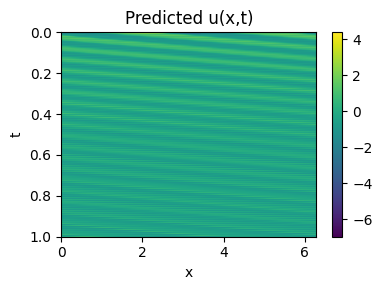

In [7]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(512,201)

mat = scipy.io.loadmat('./AC.mat')
u = mat['uu'].reshape(512,201)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()

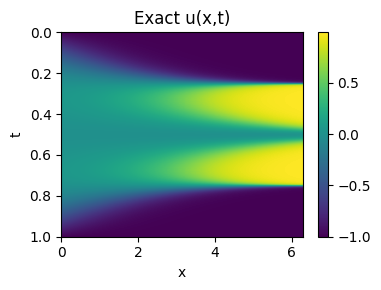

In [8]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact.png')
plt.show()

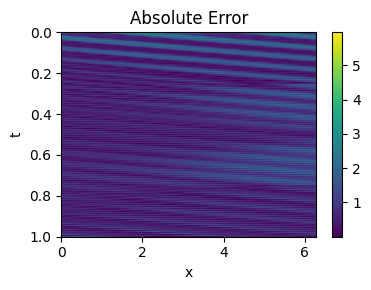

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinnsformer_error.png')
plt.show()